In [69]:
import pandas as pd
from datetime import datetime
import haversine as hs
from haversine import Unit
import time
import matplotlib.pyplot as plt
from scipy.stats import zscore
import seaborn as sns
import numpy as np
from scipy.stats.stats import pearsonr
from sklearn.linear_model import LogisticRegression

/var/folders/bg/hyfz4snj4hz8rkdrzj4xgjjw0000gn/T/ipykernel_92003/3735220347.py:10: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


## Download Data

In [2]:
# Download Base Data
path = r'datathon_2024_dataset.csv'
baseball_df = pd.read_csv(path).iloc[:, 1:] # just to remove the indexing column

# Download City Data
city_path = r'city_cords.csv'
city_df = pd.read_csv(city_path)
city_cords = city_df[['city', 'lat', 'lng']]

# Download pbp data
pbp_path = r'all_season_pbp.csv'
pbp_df = pd.read_csv(pbp_path).iloc[:, 2:]

# Download game distance data
dist_path = r'datathon2024_data_w_dist.csv'
dist_df = pd.read_csv(dist_path).iloc[:,1:]


## Merge Data
baseball_df = baseball_df.merge(city_cords, on='city', how='left')

/var/folders/bg/hyfz4snj4hz8rkdrzj4xgjjw0000gn/T/ipykernel_92003/1241583956.py:12: DtypeWarning: Columns (45,89,90) have mixed types. Specify dtype option on import or set low_memory=False.
  pbp_df = pd.read_csv(pbp_path).iloc[:, 2:]


## Clean pbp

In [3]:
# get only the regular season game
pbp_df = pbp_df[pbp_df['game_type'] == 'R']

In [44]:
pbp_df.columns

Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'zone', 'des', 'game_type', 'stand',
       'p_throws', 'home_team', 'away_team', 'type', 'hit_location', 'bb_type',
       'balls', 'strikes', 'game_year', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z',
       'on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'inning', 'inning_topbot',
       'hc_x', 'hc_y', 'umpire', 'sv_id', 'vx0', 'vy0', 'vz0', 'ax', 'ay',
       'az', 'sz_top', 'sz_bot', 'hit_distance_sc', 'launch_speed',
       'launch_angle', 'effective_speed', 'release_spin_rate',
       'release_extension', 'game_pk', 'pitcher.1', 'release_pos_y',
       'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle',
       'woba_value', 'woba_denom', 'babip_value', 'iso_value',
       'launch_speed_angle', 'at_bat_number', 'pitch_number', 'pitch_name',
       'home_score', 'away_score', 'bat_score', 'fld_score', 'pos

In [45]:
# column docs: https://baseballsavant.mlb.com/csv-docs
pbp_df.columns
# drop all columns that were deprecated
pbp_df = pbp_df.drop([col for col in pbp_df.columns if 'deprecated' in col], axis=1)
# drop all the fielder columns
pbp_df = pbp_df.drop([col for col in pbp_df.columns if 'fielder' in col], axis=1)
# take only 

# seperate into columns that we need 
pitch_details = ['pitcher','p_throws', 'pitch_type','zone',
                 'pfx_x','pfx_z','plate_x','plate_z', # movement and placement
                'vx0','vy0','vz0','ax','ay','az', # accelerations and velocities
                 'effective_speed','release_spin_rate','release_extension', 'pitch_name',
                ]

batter_details = ['stand', 'bb_type', 'sz_bot','sz_top',
                 'hc_x','hc_y', # hit coordinates
                 'hit_distance_sc', 'launch_speed', 'launch_speed_angle', # hit details
                  'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle', # hit results
                  'at_bat_number',
                 ]

results = ['delta_home_win_exp', 'delta_run_exp', 'des', 'description']

situation_details = ['balls','strikes','on_1b','on_2b','on_3b','outs_when_up']

team_details = ['home_team','away_team','home_score', 'away_score', 'bat_score', 'fld_score']

# combine into a pbp details df
pbp_details = pbp_df[['game_date','game_pk','sv_id', 'pitch_number', 'inning', 'inning_topbot'] + situation_details + pitch_details + batter_details + team_details + results]

In [46]:
# create an at bat ID and pitch ID

# sort df
pbp_details = pbp_details.sort_values(by = ['game_date','game_pk','inning', 'outs_when_up','at_bat_number','pitch_number'])

# combine game ID, top/bottom of inning, and AB #
pbp_details['at_bat_id'] = str(pbp_details['game_pk']) + str(pbp_details['inning_topbot']) + str(pbp_details['at_bat_number'])
# add pitch number for pitch id
pbp_details['ptich_id'] = pbp_details['at_bat_id'] + str(pbp_details['pitch_number'])

In [47]:
# make a pitch count 
pbp_details['pitch_count'] = pbp_details.groupby(['game_pk', 'pitcher']).cumcount() + 1

In [48]:
# save a df of pbp data after 2015 (more manageable)
#pbp_details[pbp_details['season'] > 2015].to_csv('pbp_after_2015.csv')

## Join PBP with travel data

In [49]:
# get the dates in the same format
pbp_details['date_merge'] = pbp_details['game_date'].str.replace('-', '')
pbp_details['date_merge'] = pbp_details['date_merge'].apply(lambda x: int(x))

In [50]:
pbp_with_dist = pbp_details.merge(dist_df, left_on = ['game_date','home_team','away_team'], 
                  right_on = ['game_date','home_team','away_team'])

In [51]:
pbp_with_dist

,game_date,game_pk,sv_id,pitch_number,inning,inning_topbot,balls,strikes,on_1b,on_2b,...,home_last_time_zone,away_last_time_zone,home_time_between_games,away_time_between_games,home_time_since_last_series,away_time_since_last_series,home_distance_travelled_game,away_distance_travelled_game,home_distance_travelled_series,away_distance_travelled_series
0,2008-03-25,233757,NaN,1,1,Top,0,0,NaN,NaN,...,-8.0,-5.0,177,177.0,177,177.0,8283.703646,10793.893778,8283.703646,10793.893778
1,2008-03-25,233757,NaN,2,1,Top,0,1,NaN,NaN,...,-8.0,-5.0,177,177.0,177,177.0,8283.703646,10793.893778,8283.703646,10793.893778
2,2008-03-25,233757,NaN,1,1,Top,0,0,456030.0,NaN,...,-8.0,-5.0,177,177.0,177,177.0,8283.703646,10793.893778,8283.703646,10793.893778
3,2008-03-25,233757,NaN,2,1,Top,0,1,456030.0,NaN,...,-8.0,-5.0,177,177.0,177,177.0,8283.703646,10793.893778,8283.703646,10793.893778
4,2008-03-25,233757,NaN,3,1,Top,1,1,456030.0,NaN,...,-8.0,-5.0,177,177.0,177,177.0,8283.703646,10793.893778,8283.703646,10793.893778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10186399,2023-10-01,716367,NaN,2,9,Bot,0,1,NaN,NaN,...,-5.0,-5.0,1,1.0,4,4.0,0.000000,0.000000,0.000000,578.639735
10186400,2023-10-01,716367,NaN,3,9,Bot,0,2,NaN,NaN,...,-5.0,-5.0,1,1.0,4,4.0,0.000000,0.000000,0.000000,578.639735
10186401,2023-10-01,716367,NaN,4,9,Bot,1,2,NaN,NaN,...,-5.0,-5.0,1,1.0,4,4.0,0.000000,0.000000,0.000000,578.639735
10186402,2023-10-01,716367,NaN,5,9,Bot,2,2,NaN,NaN,...,-5.0,-5.0,1,1.0,4,4.0,0.000000,0.000000,0.000000,578.639735


## PBP Pitcher Analysis

Ideas for pitching valuable statistics:
- velo for FF
- Vertical Delta on SL SI
- Strike out rate
- Walk rate
- Release Extension
- Quality start reate (at least six innings with no more than three earned runs)

In [52]:
pbp_with_dist.columns

Index(['game_date', 'game_pk', 'sv_id', 'pitch_number', 'inning',
       'inning_topbot', 'balls', 'strikes', 'on_1b', 'on_2b', 'on_3b',
       'outs_when_up', 'pitcher', 'p_throws', 'pitch_type', 'zone', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'effective_speed', 'release_spin_rate', 'release_extension',
       'pitch_name', 'stand', 'bb_type', 'sz_bot', 'sz_top', 'hc_x', 'hc_y',
       'hit_distance_sc', 'launch_speed', 'launch_speed_angle',
       'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle',
       'at_bat_number', 'home_team', 'away_team', 'home_score_x',
       'away_score_x', 'bat_score', 'fld_score', 'delta_home_win_exp',
       'delta_run_exp', 'des', 'description', 'at_bat_id', 'ptich_id',
       'pitch_count', 'date_merge', 'is_day_game', 'home_score_y',
       'away_score_y', 'venue', 'venue_name', 'city', 'state', 'away_pa',
       'away_1b', 'away_2b', 'away_3b', 'away_hr', 'away_fo', 'away_so',
   

In [53]:
# get all of the time/distance metrics for specific pitchers
def get_pitcher_dist_game(row):
    if row['inning_topbot'] == 'Top':
        return row['home_distance_travelled_game']
    return row['away_distance_travelled_game']

def get_pitcher_dist_series(row):
    if row['inning_topbot'] == 'Top':
        return row['home_distance_travelled_series']
    return row['away_distance_travelled_series']

def get_pitcher_time_games(row):
    if row['inning_topbot'] == 'Top':
        return row['home_time_between_games']
    return row['away_time_between_games']

def get_pitcher_time_series(row):
    if row['inning_topbot'] == 'Top':
        return row['home_time_since_last_series']
    return row['away_time_since_last_series']

def get_pitcher_time_zone_dif(row):
    if row['inning_topbot'] == 'Top':
        return row['time_zone'] - row['home_last_time_zone']
    return row['time_zone'] - row['away_last_time_zone']

now = time.time()
pbp_with_dist['pitcher_distance_traveled_game'] = pbp_with_dist.apply(get_pitcher_dist_game, axis = 1)
print(now - time.time())
now = time.time()
pbp_with_dist['pitcher_distance_traveled_series'] = pbp_with_dist.apply(get_pitcher_dist_series, axis = 1)
print(now - time.time())
now = time.time()
pbp_with_dist['pitcher_time_between_games'] = pbp_with_dist.apply(get_pitcher_time_games, axis = 1)
print(now - time.time())
now = time.time()
pbp_with_dist['pitcher_time_between_series'] = pbp_with_dist.apply(get_pitcher_time_series, axis = 1)
print(now - time.time())
now = time.time()
pbp_with_dist['pitcher_time_zone_dif'] = pbp_with_dist.apply(get_pitcher_time_zone_dif, axis = 1)
print(now - time.time())

-48.736083984375
-45.549230098724365
-45.70401978492737
-46.17483401298523
-51.072312116622925


In [54]:
pbp_with_dist['pitcher_time_zone_dif_abs'] = np.abs(pbp_with_dist['pitcher_time_zone_dif'])

In [55]:
# start with just 2023 season
pbp_with_dist['season'] = pbp_with_dist['game_date'].apply(lambda x: int(x[:4]))
pbp_2023 = pbp_with_dist[pbp_with_dist['season'] == 2023]

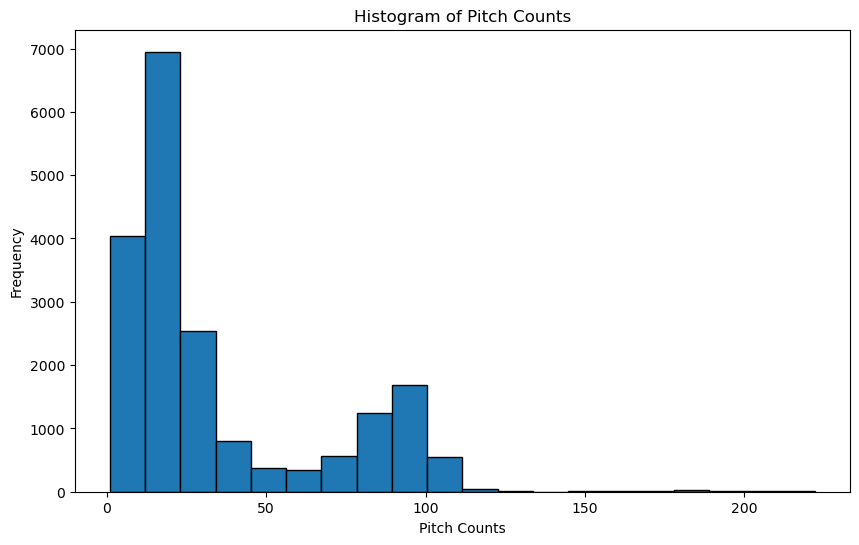

In [56]:
# take starting pitchers only

# get pitch counts by game
pitch_counts = pbp_2023.groupby(by = ['pitcher','game_pk']).count().reset_index()

# make a histogram of the counts (try to differentiate starter/closer)

# Assuming df is your DataFrame and 'column_name' is your column
plt.figure(figsize=(10,6))
plt.hist(pitch_counts['game_date'], bins=20, edgecolor='black')

plt.title('Histogram of Pitch Counts')
plt.xlabel('Pitch Counts')
plt.ylabel('Frequency')

plt.show() # lets split at 60

In [57]:
# take only the starters
pitch_counts_starters = pitch_counts[pitch_counts['game_date'] > 60][['pitcher','game_pk','game_date']]
pitch_counts_starters['pitch_count_total'] = pitch_counts_starters['game_date']
pitch_counts_starters = pitch_counts_starters.drop(columns = ['game_date'])
starter_pbp_2023 = pbp_2023.merge(pitch_counts_starters, on = ['pitcher','game_pk'])

In [58]:
starter_pbp_2023.columns

Index(['game_date', 'game_pk', 'sv_id', 'pitch_number', 'inning',
       'inning_topbot', 'balls', 'strikes', 'on_1b', 'on_2b',
       ...
       'home_distance_travelled_series', 'away_distance_travelled_series',
       'pitcher_distance_traveled_game', 'pitcher_distance_traveled_series',
       'pitcher_time_between_games', 'pitcher_time_between_series',
       'pitcher_time_zone_dif', 'pitcher_time_zone_dif_abs', 'season',
       'pitch_count_total'],
      dtype='object', length=104)

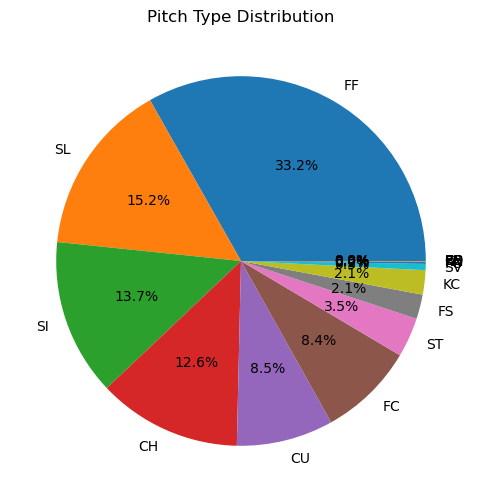

In [59]:
# get pitch value counts - quick pie chart visual
pitch_type_counts = starter_pbp_2023['pitch_type'].value_counts()

plt.figure(figsize=(10,6))
plt.pie(pitch_type_counts, labels = pitch_type_counts.index, autopct='%1.1f%%')
plt.title('Pitch Type Distribution')
plt.show()

### Which pitch metrics are most impactful to causing a swing and a miss?

In [263]:
pitch_type_dict = {}

# get z-score norm by all pitching stats by pitcher by pitch type
for pitch_type in set(pbp_with_dist['pitch_type']):
    df = pbp_with_dist[pbp_with_dist['pitch_type'] == pitch_type].copy()
    for detail in pitch_details:
        if detail in ['pitcher','p_throws','pitch_type','zone','des', 'pitch_name']:
            pass
        # check the datatype
        if df[detail].dtype.kind in 'biufc':
            # fill any null vals
            df[detail] = df[detail].fillna(df[detail].mean())
            df[detail + '_norm'] = df.groupby('pitcher')[detail].transform(zscore)
    
    pitch_type_dict[pitch_type] = df
    

In [219]:
pitch_type_dict['SI'][[col for col in df.columns if "norm" in col]]

,zone_norm,pfx_x_norm,pfx_z_norm,plate_x_norm,plate_z_norm,vx0_norm,vy0_norm,vz0_norm,ax_norm,ay_norm,az_norm,effective_speed_norm,release_spin_rate_norm,release_extension_norm
9496906,1.045473,-1.472273,0.038286,-1.247081,-0.193034,-0.241426,0.584437,-0.311861,-1.039427,0.795124,0.092678,-0.771455,0.367137,-0.351985
9496909,0.561163,-1.294674,0.378872,-0.850169,0.468212,0.030670,0.472527,0.258184,-0.997739,0.537371,0.283292,-0.546867,0.287033,0.207225
9496910,-0.891765,-1.205875,-0.097949,0.290955,-0.165482,0.962265,-0.386859,-0.462014,-1.501503,0.466734,0.054075,0.276619,-1.128134,-0.351985
9496917,-0.165301,-0.850678,0.583224,0.427394,-0.757849,1.273979,-1.002103,-1.166667,-1.539105,0.718388,0.892617,1.100106,0.834409,0.766436
9496925,0.076854,-1.738671,-0.506652,0.737481,-0.620089,1.776162,-0.614486,-0.821330,-2.300853,-0.221456,-0.231538,0.501207,0.914513,-0.911196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10186365,1.334625,-0.587155,0.596452,0.893148,0.151446,0.882169,1.853139,0.235130,-1.100193,-0.428274,0.121559,-0.193702,-1.258723,0.768751
10186367,-0.889750,0.689744,-1.205098,-0.813680,0.238272,-0.702212,1.503807,0.604711,0.405351,0.258949,-1.400714,-0.169225,-0.103330,0.110823
10186377,-1.878361,0.405988,-0.052106,-0.963402,1.077595,-0.708042,2.068283,1.240878,0.026828,-0.477026,-0.645749,-0.267135,0.087366,-0.547104
10186385,-1.136903,-0.303400,0.019956,-1.202957,0.180388,-0.854091,0.472386,0.150897,-0.225063,0.005562,-0.098832,-0.010121,1.040846,-0.547104


In [264]:
feature_dict = {}

# get best predictors of swining_strike by pitch type
for pitch_type in set(pbp_with_dist['pitch_type']):
    print(pitch_type)
    
    df = pitch_type_dict[pitch_type].copy()
    
    df = df.drop(columns = ['pitcher_norm'])
    
    # mark a pitch successful if the pitch was a swining strike
    df['success'] = df['description'].apply(lambda x: x == "swinging_strike")
    
    if len(list(set(df['success']))) != 2:
        continue
        
    # take out smaller data
    if df.shape[0] < 10000:
        continue
    
    # remove any NA cols
    #print(df)
    #df = df.dropna(axis = 0)
    #print(df.shape)
    
    # fit a linear regression model to get feature importances
    model = LogisticRegression()
    
    cols_to_use = [col for col in df.columns if 'norm' in col]
    cols_to_use = [col for col in cols_to_use if col not in ['pitcher_norm']]
    
    # get the columns we're using 
    x_vals = df[cols_to_use + ['success']]
    x_vals = x_vals.dropna(axis = 0)
    y = x_vals['success']
    
    
    x_vals = x_vals.drop(columns = ['success']).copy()
    
    
    # fit the log model
    model.fit(x_vals, y)

    # Get the feature importances
    coefficients = model.coef_[0]

    # Create a DataFrame with the feature names and their importances
    feature_importances = pd.DataFrame({'Feature': x_vals.columns, 'Importance': coefficients})

    # Sort the DataFrame by importance
    feature_importances = feature_importances.sort_values('Importance', ascending=False)
    
    feature_dict[pitch_type] = feature_importances
    

KC
(200194, 118)
CU
(796354, 118)
FA
CS
SI
(2057164, 118)
IN
SV
(15153, 118)
AB
EP
FO
KN
(34530, 118)
SC
SL
(1572669, 118)
FS
(162996, 118)
PO
CH
(1060937, 118)
FC
(615103, 118)
FF
(3492666, 118)
nan
ST
(80547, 118)


In [265]:
feature_dict['FF']

,Feature,Importance
10,az_norm,0.629732
7,vz0_norm,0.529989
1,pfx_x_norm,0.165772
3,plate_x_norm,0.073314
12,release_spin_rate_norm,0.049681
4,plate_z_norm,0.012451
11,effective_speed_norm,0.000083
13,release_extension_norm,-0.011537
5,vx0_norm,-0.022862
9,ay_norm,-0.060991


In [275]:
travel_metrics = ['pitcher_distance_traveled_game', 'pitcher_distance_traveled_series',
                  'pitcher_time_between_games',  'pitcher_time_between_series', 'pitcher_time_zone_dif',
                 'pitcher_time_zone_dif_abs']

all_impacts_dict = {}

In [271]:
pbp_with_dist_in_season = pbp_with_dist[pbp_with_dist['pitcher_time_between_series'] <= 4]

In [283]:
pitch_type_dict['FF'][travel_metrics]

,pitcher_distance_traveled_game,pitcher_distance_traveled_series,pitcher_time_between_games,pitcher_time_between_series,pitcher_time_zone_dif,pitcher_time_zone_dif_abs
621,1803.882425,1803.882425,183.0,183.0,-1.0,1.0
623,2531.885773,2531.885773,183.0,183.0,2.0,2.0
624,2531.885773,2531.885773,183.0,183.0,2.0,2.0
625,2531.885773,2531.885773,183.0,183.0,2.0,2.0
627,2531.885773,2531.885773,183.0,183.0,2.0,2.0
...,...,...,...,...,...,...
10186382,0.000000,578.639735,1.0,4.0,0.0,0.0
10186387,0.000000,578.639735,1.0,4.0,0.0,0.0
10186391,0.000000,578.639735,1.0,4.0,0.0,0.0
10186398,0.000000,578.639735,1.0,4.0,0.0,0.0


In [288]:
# check on the impact of all these things over our travel metrics

all_pitch_dict = {}

for pitch_type in feature_dict.keys():


    feature_impact_dict = {}

    # get only that pitch type 
    pitch_df = pitch_type_dict[pitch_type]
    
    print(pitch_type)

    for feature in set(feature_dict[pitch_type]['Feature']):
        #print(feature)
        now = time.time()

        impacts_dict = {}

        # loop over all travel metric
        for metric in travel_metrics:
        # calc corr and p-val
            pitch_df = pitch_df.dropna(axis = 0, subset = [metric, feature])
            correlation, p_value = pearsonr(pitch_df[metric], pitch_df[feature])
            # add values to dictionary

            # plot scatter plot
            #fig, ax = plt.subplots()

            #sns.scatterplot(data=pitch_df, x=metric, y='vy0_norm')

            # main title
            #fig.suptitle(metric + ' vs. vy0_norm', style ='oblique', family='monospace')

            # Set the subtitle with custom style
            #ax.set_title('Corr: ' + str(correlation) + ", p-val: " + str(p_value), fontsize='medium', fontweight='normal', style='italic', family='monospace')

            #plt.xlabel(metric)
            #plt.ylabel('Velo (z-score)')

            #plt.show()

            # add pears and p-val to feature_dict
            impacts_dict[metric] = correlation, p_value

        #print(time.time() - now)
        feature_impact_dict[feature] = impacts_dict

    all_pitch_dict[pitch_type] = feature_impact_dict


KC
ax_norm
0.35567784309387207
vz0_norm
0.20314908027648926
release_extension_norm
0.2122650146484375
az_norm
0.19115805625915527
pfx_z_norm
0.19097113609313965
plate_z_norm
0.18595623970031738
zone_norm
0.19544601440429688
vy0_norm
0.19283199310302734
vx0_norm
0.19560980796813965
release_spin_rate_norm
0.1893610954284668
ay_norm
0.1905679702758789
effective_speed_norm
0.18822908401489258
plate_x_norm
0.18866682052612305
pfx_x_norm
0.18587112426757812
CU
ax_norm
2.2020280361175537
vz0_norm
0.7295248508453369
release_extension_norm
0.6905460357666016
az_norm
0.6028420925140381
pfx_z_norm
0.609321117401123
plate_z_norm
0.600196123123169
zone_norm
0.6411762237548828
vy0_norm
0.6183772087097168
vx0_norm
0.6278038024902344
ay_norm
0.6138420104980469
release_spin_rate_norm
0.7082290649414062
effective_speed_norm
0.6155378818511963
plate_x_norm
0.6523542404174805
pfx_x_norm
0.6044700145721436
SI
ax_norm
5.602704286575317
vz0_norm
2.3651909828186035
release_extension_norm
1.9587488174438477
az

In [301]:
all_pitch_dict['FF']['ax_norm']
all_pitch_dict['FF']['ax_norm']['pitcher_distance_traveled_game']

(0.010598856641759455, 2.5223321298515457e-87)

In [328]:
100 - sum([33.2, 15.2, 13.7, 12.6, 8.5, 8.4])

8.399999999999991

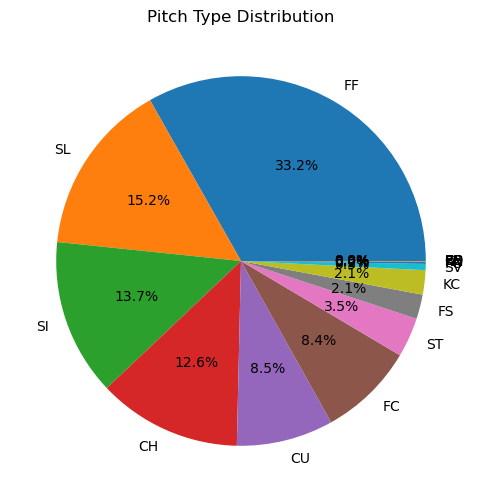

In [303]:
# get pitch value counts - quick pie chart visual
pitch_type_counts = starter_pbp_2023['pitch_type'].value_counts()

plt.figure(figsize=(10,6))
plt.pie(pitch_type_counts, labels = pitch_type_counts.index, autopct='%1.1f%%')
plt.title('Pitch Type Distribution')
plt.show()

In [324]:
feature_dict['FF']

,Feature,Importance
10,az_norm,0.629732
7,vz0_norm,0.529989
1,pfx_x_norm,0.165772
3,plate_x_norm,0.073314
12,release_spin_rate_norm,0.049681
4,plate_z_norm,0.012451
11,effective_speed_norm,0.000083
13,release_extension_norm,-0.011537
5,vx0_norm,-0.022862
9,ay_norm,-0.060991


In [330]:
all_pitch_dict['FF']['pfx_x_norm']

{'pitcher_distance_traveled_game': (0.011276069602011277,
  9.323879621260311e-85),
 'pitcher_distance_traveled_series': (0.009945124565982441,
  2.4103628880479424e-66),
 'pitcher_time_between_games': (-0.008907476708826634, 1.394660378260688e-53),
 'pitcher_time_between_series': (-0.007970826157296154, 2.934035008273725e-43),
 'pitcher_time_zone_dif': (0.017432347049949535, 7.82283130852831e-200),
 'pitcher_time_zone_dif_abs': (0.001997160850729477, 0.0005500579592190586)}

In [ ]:
travel_feature = 'pitcher_time_zone_dif_abs'

### Storage for impacts/z-scores

In [20]:
travel_metrics = ['pitcher_distance_traveled_game', 'pitcher_distance_traveled_series',
                  'pitcher_time_between_games',  'pitcher_time_between_series', 'pitcher_time_zone_dif',
                 'pitcher_time_zone_dif_abs']

all_impacts_dict = {}
velo_impact = {}

## Go through pitch impacts

In [21]:
# fast ball velo impact

# get only FF
pbp_2023_ff = starter_pbp_2023[starter_pbp_2023['pitch_type'] == "FF"].copy()

# get the z-score for velocity
pbp_2023_ff['vy0_norm'] = pbp_2023_ff.groupby('pitcher')['vy0'].transform(zscore)

# get mean z-score by game 
numeric_cols = pbp_2023_ff.select_dtypes(include=['int64', 'float64']).columns
pbp_2023_ff_game = pbp_2023_ff[['pitcher','game_pk']+list(numeric_cols)].groupby(by = ['pitcher','game_pk']).mean().reset_index()

In [22]:
set(starter_pbp_2023['pitcher_time_between_games'])

{0.0, 1.0, 2.0, 3.0, 5.0, 6.0, 176.0}

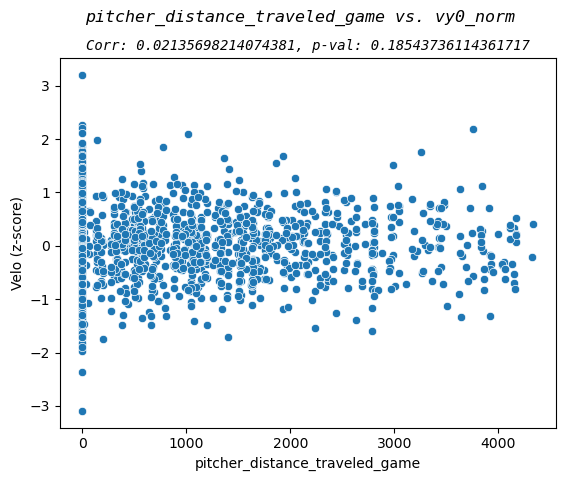

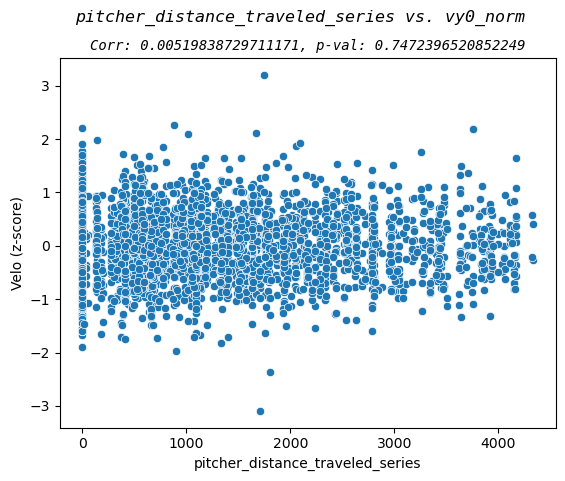

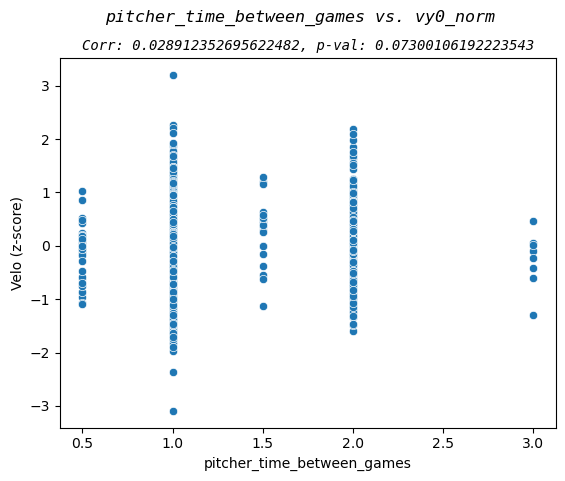

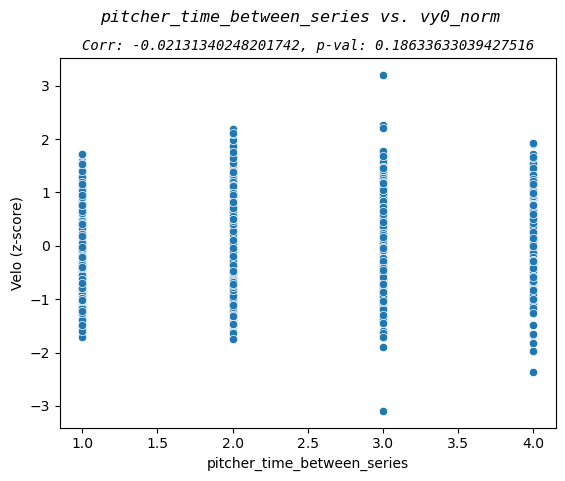

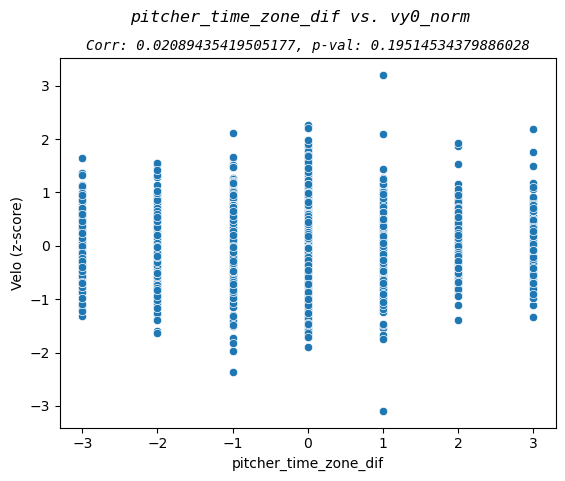

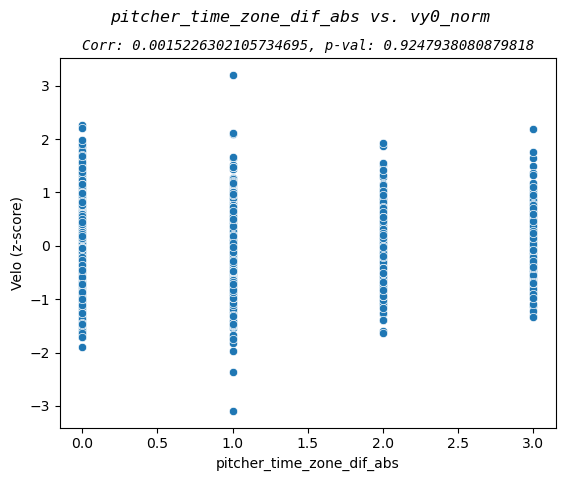

In [23]:
# check the impact on fastball velo over our travel metrics

# drop any nulls for vy0_norm
pbp_2023_ff_game = pbp_2023_ff_game.dropna(axis = 0, subset = ['vy0_norm'])
# drop the games at the begining of the season
pbp_2023_ff_game = pbp_2023_ff_game[pbp_2023_ff_game['pitcher_time_between_series'] <= 4]

# loop over all travel metric
for metric in travel_metrics:
    # calc corr and p-val
    correlation, p_value = pearsonr(pbp_2023_ff_game[metric], pbp_2023_ff_game['vy0_norm'])
    # add values to dictionary
    
    # plot scatter plot
    fig, ax = plt.subplots()
    
    sns.scatterplot(data=pbp_2023_ff_game, x=metric, y='vy0_norm')

    # main title
    fig.suptitle(metric + ' vs. vy0_norm', style ='oblique', family='monospace')

    # Set the subtitle with custom style
    ax.set_title('Corr: ' + str(correlation) + ", p-val: " + str(p_value), fontsize='medium', fontweight='normal', style='italic', family='monospace')
    
    plt.xlabel(metric)
    plt.ylabel('Velo (z-score)')

    plt.show()

In [24]:
# spin rate on FF


## Predictions 

## Get pitcher data

In [183]:
def is_pitcher_home(top_bot):
    if top_bot == 'Top':
        return 'Home'
    return "Away"

In [150]:
game_count  = pbp_with_dist.groupby(by = ['game_pk','pitcher']).count().reset_index()
game_count = game_count[game_count['game_date'] > 60]
game_count = game_count[['game_pk','pitcher','game_date']]
game_count['pitch_count'] = game_count['game_date']
game_count = game_count.drop(columns = ['game_date'])

pbp_all_starters = pbp_with_dist.merge(game_count, on = ['game_pk','pitcher'])

In [184]:
pbp_all_starters['home_away'] = pbp_all_starters['inning_topbot'].apply(lambda x: is_pitcher_home(x))

In [210]:
pitcher_max = pbp_all_starters.groupby(by = ['game_pk','pitcher', 'game_date', 'home_team','away_team', 'home_away']).max(numeric_only = True).reset_index()



In [211]:
pitcher_max['earned_runs'] = pitcher_max['bat_score']

In [212]:
pitcher_er = pitcher_max[['game_pk','game_date','home_team', 'away_team', 'earned_runs', 'home_away']]

In [213]:
pitcher_sum = pbp_all_starters.groupby(by = ['game_pk','pitcher', 'game_date', 'home_team','away_team', 'home_away']).sum(numeric_only = True).reset_index()
pitcher_b_s = pitcher_sum[['game_pk','pitcher', 'game_date', 'home_team','away_team','balls','strikes', 'home_away']]

In [214]:
pitcher_info = pitcher_er.merge(pitcher_b_s)

In [215]:
def calc_so(row):
    if row['home_away'] == 'Home':
        return row['home_so']
    return row['away_so']

pbp_all_starters['pitcher_so'] = pbp_all_starters.apply(calc_so, axis = 1)

In [216]:
pitcher_max_so = pbp_all_starters.groupby(by = ['game_pk','pitcher', 'game_date', 'home_team','away_team', 'home_away']).max(numeric_only = True).reset_index()
pitcher_max_so = pitcher_max_so[['game_pk','pitcher', 'game_date', 'home_team','away_team', 'home_away','pitcher_so']]
pitcher_info = pitcher_info.merge(pitcher_max_so, on = ['game_pk','pitcher', 'game_date', 'home_team','away_team', 'home_away'])


In [218]:
pitcher_info.to_csv('pitcher_info.csv')

In [225]:
def home_away_combine_er(row):
    if row['home_away'] == 'Home':
        return row['earned_runs']
    return 0

pitcher_info['home_earned_runs'] = pitcher_info.apply(home_away_combine_er, axis = 1)

def away_combine_er(row):
    if row['home_away'] == 'Away':
        return row['earned_runs']
    return 0

pitcher_info['away_earned_runs'] = pitcher_info.apply(away_combine_er, axis = 1)

def home_pitcher(row):
    if row['home_away'] == 'Home':
        return row['pitcher']
    return 0

pitcher_info['home_pitcher'] = pitcher_info.apply(home_pitcher, axis = 1)

def away_pitcher(row):
    if row['home_away'] == 'Away':
        return row['pitcher']
    return 0

pitcher_info['away_pitcher'] = pitcher_info.apply(away_pitcher, axis = 1)

def home_so(row):
    if row['home_away'] == 'Home':
        return row['pitcher_so']
    return 0

pitcher_info['home_so'] = pitcher_info.apply(home_so, axis = 1)

def away_so(row):
    if row['home_away'] == 'Away':
        return row['pitcher_so']
    return 0

pitcher_info['away_so'] = pitcher_info.apply(away_so, axis = 1)


In [229]:
pitcher_info_game = pitcher_info.groupby(by = ['game_pk', 'game_date', 'home_team','away_team']).max().reset_index()

In [261]:
pitcher_stats = pitcher_info_game.drop(columns = ['earned_runs','home_away','pitcher','balls','strikes','pitcher_so'])



In [233]:
pitcher_stats.to_csv('pitcher_info.csv')

In [248]:
pitcher_stats['game_date'] = pitcher_stats['game_date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))

In [255]:
pitcher_stats['month'] = pitcher_stats['game_date'].apply(lambda x: x.month)
pitcher_stats['year'] = pitcher_stats['game_date'].apply(lambda x: x.year)

In [256]:
sum_stats = pitcher_stats[pitcher_stats['month'] < 7]
sum_stats

,game_pk,game_date,home_team,away_team,home_earned_runs,away_earned_runs,home_pitcher,away_pitcher,home_so,away_so,month,year
0,233757,2008-03-25,OAK,BOS,2,2,430599,493137,10,7,3,2008
1,233758,2008-03-26,OAK,BOS,1,4,425848,452657,7,13,3,2008
2,233760,2008-03-31,MIN,LAA,2,3,115817,450308,6,5,3,2008
3,233761,2008-03-31,CIN,AZ,3,2,421685,425630,10,9,3,2008
4,233762,2008-03-31,CLE,CWS,4,0,282332,0,9,0,3,2008
...,...,...,...,...,...,...,...,...,...,...,...,...
33726,718777,2023-03-30,CHC,MIL,0,4,573186,669203,5,12,3,2023
33727,718778,2023-03-30,SD,COL,1,2,605483,608566,10,17,3,2023
33728,718779,2023-03-30,TEX,PHI,4,5,594798,605400,8,13,3,2023
33729,718781,2023-03-30,NYY,SF,0,3,543037,657277,16,16,3,2023


## PBP Batter Analysis

## Formulas

In [25]:
def get_haversine_distance(row):
    city1 = (row['last_lat'], row['last_lng'])
    city2 = (row['lat'], row['lng'])

    return hs.haversine(city1, city2, unit=hs.Unit.KILOMETERS)


## Clean Data

In [26]:
# convert to datetime formatting
baseball_df['game_date'] = pd.to_datetime(baseball_df['game_date'], format = "%Y%m%d") #change to yyyy-mm-dd

# add home win column
baseball_df['home_win']= [1 if x>y else 0 for x,y in zip(baseball_df['home_score'],baseball_df['away_score'])] #1 if home team won, 0 else

#FlO = MON
baseball_df.loc[baseball_df['home_team']=='FLO','home_team'] = 'MIA'
baseball_df.loc[baseball_df['away_team'] == 'FLO','away_team'] = 'MIA'

In [27]:
# get the schedule for each team
unique_teams = pd.unique(pd.concat([baseball_df['home_team'], baseball_df['away_team']]))

# loop thru to make a dictionary for each team adding the time between games and the distance travelled between each game
team_schedules = {}
for team in unique_teams:

    all_team_games = baseball_df[(baseball_df['home_team'] == team) | (baseball_df['away_team'] == team)]
    all_team_games = all_team_games.sort_values(by='game_date', ascending=True).reset_index(drop=True)
    all_team_games['time_between_games'] = all_team_games['game_date'] - all_team_games['game_date'].shift(1)

    all_team_games['last_lat'] = all_team_games['lat'].shift(1)
    all_team_games['last_lng'] = all_team_games['lng'].shift(1)

    all_team_games['distance_travelled'] = all_team_games.apply(get_haversine_distance, axis=1)

    team_schedules[team] = all_team_games


In [41]:
unique_teams

array(['NYN', 'CHN', 'ATL', 'CIN', 'MIA', 'MON', 'SLN', 'ANA', 'BAL',
       'MIN', 'OAK', 'TEX', 'TOR', 'ARI', 'PIT', 'SEA', 'HOU', 'KCA',
       'TBA', 'COL', 'MIL', 'PHI', 'SDN', 'SFN', 'BOS', 'DET', 'NYA',
       'LAN', 'CHA', 'CLE', 'WAS'], dtype=object)